In [2]:
#HTML 크롤링
#날짜 탐색기능이 추가된 전체함수
from urllib.request import urlopen
import bs4
import datetime as dt

def date_format_html(d):
    d = str(d).replace('-', '.') # 날짜가 -로 구분되어있을 경우 .로 바꿈
    yyyy=int(d.split('.')[0])
    mm=int(d.split('.')[1])
    dd=int(d.split('.')[2])
    
    this_date = dt.date(yyyy,mm,dd)
    return this_date

def historical_index_naver_date(index_cd, start_date='', end_date='', page_n=1, last_page=0):
    if start_date: #start_date가 있으면
        start_date=date_format_html(start_date)
    else: #없으면
        start_date = dt.date.today() #오늘날짜 지정
    if end_date : #end_date가 있으면
        end_date=date_format_html(end_date)
    else:
            end_date=dt.date.today()
    
    naver_index = 'https://finance.naver.com/sise/sise_index_day.nhn?code=' + index_cd + '&page=' + str(page_n) #일별시세-프레임소스보기
    source = urlopen(naver_index).read()
    source = bs4.BeautifulSoup(source, 'lxml') 
    
    dates=source.find_all('td',class_='date') #<td class ="date">태그에서 날짜수집
    prices=source.find_all('td', class_='number_1') #<td class = "number_1">태그에서 지수수집
    
    for n in range(len(dates)): #dates개수만큼 반복
        if dates[n].text.split('.')[0].isdigit():
            #날짜처리
            this_date = dates[n].text
            this_date = date_format_html(this_date)
            
            if this_date <= end_date and this_date >= start_date:
                #종가처리
                this_close=prices[n*4].text
                this_close=this_close.replace(',', '') 
                this_close=float(this_close)
                this_close
    
                #딕셔너리에 저장
                historical_prices_date[this_date] = this_close
            
            elif this_date < start_date:
                return historical_prices_date
    
    #페이지 네비게이션
    if last_page ==0:
        last_page = source.find('td',class_='pgRR').find('a')['href']
        #마지막페이지 주소 추출
        last_page = last_page.split('&')[1]
        last_page = last_page.split('=')[1]
        last_page=int(last_page)
    
    #다음페이지 호출
    if page_n < last_page:
        page_n = page_n +1
        historical_index_naver_date(index_cd, start_date, end_date, page_n, last_page)
    
    return historical_prices_date

historical_prices_date=dict()
historical_prices_date=historical_index_naver_date('KPI200', '2020.6.20', '2020.7.20')
historical_prices_date

{datetime.date(2020, 7, 20): 290.81,
 datetime.date(2020, 7, 17): 291.57,
 datetime.date(2020, 7, 16): 289.25,
 datetime.date(2020, 7, 15): 292.27,
 datetime.date(2020, 7, 14): 289.63,
 datetime.date(2020, 7, 13): 289.84,
 datetime.date(2020, 7, 10): 285.06,
 datetime.date(2020, 7, 9): 287.25,
 datetime.date(2020, 7, 8): 285.97,
 datetime.date(2020, 7, 7): 286.77,
 datetime.date(2020, 7, 6): 290.62,
 datetime.date(2020, 7, 3): 285.89,
 datetime.date(2020, 7, 2): 283.86,
 datetime.date(2020, 7, 1): 280.26,
 datetime.date(2020, 6, 30): 280.09,
 datetime.date(2020, 6, 29): 278.04,
 datetime.date(2020, 6, 26): 283.38,
 datetime.date(2020, 6, 25): 279.73,
 datetime.date(2020, 6, 24): 286.7,
 datetime.date(2020, 6, 23): 281.94,
 datetime.date(2020, 6, 22): 281.42}

In [8]:
#JSON파일 크롤링
import pandas as pd
from urllib.request import urlopen
import json

def date_format_json(d=''):
    if d!='':
        this_date = pd.to_datetime(d).date()
    else:
        this_date = pd.Timestamp.today().date() #오늘날짜 지정
    return (this_date)

def index_global(d, symbol, start_date='', end_date='', page=1):
    
    end_date = date_format_json(end_date)
    if start_date=='':
        start_date = end_date - pd.DateOffset(months=1) #시작 날짜가 시정되지 않으면 끝 날짜보다 1달 앞으로 지정
    start_date=date_format_json(start_date)
    
    url = 'https://finance.naver.com/world/worldDayListJson.nhn?symbol=' + symbol + '&fdtc=0&page=' + str(page)
    raw = urlopen(url)
    data = json.load(raw)
    
    if len(data) > 0:
        for n in range(len(data)):
            date = pd.to_datetime(data[n]['xymd']).date()
            
            if date<= end_date and date>= start_date:
                price = float(data[n]['clos'])
                d[date] = price
            elif date <start_date:
                return (d)
        if len(data) == 10:
            page += 1
            index_global(d, symbol, start_date, end_date, page)
    
    return (d)

indices = {
    'SPI@SPX' : 'S&P500',
    'NAS@NDX' : 'Nasdaq 100',
    'BRI@BVSP' : 'Brazil BOVESPA',
    'NII@NI225' : 'Nikkei 225'
}
historical_indices = dict()
start_date = '2020.05.20'
end_date = '2020.07.20'
for key , value in indices.items():
    s = dict()
    s = index_global(s, key, start_date)
    historical_indices[value] = s
prices_df = pd.DataFrame(historical_indices)
prices_df.sort_index(inplace=True) #시계열 데이터를 정렬해주어야 함(책에 없는내용)
prices_df

,S&P500,Nasdaq 100,Brazil BOVESPA,Nikkei 225
2020-05-20,2971.61,9485.02,81319.45,NaN
2020-05-21,2948.51,9377.99,83027.09,NaN
2020-05-22,2955.45,9413.99,82173.21,NaN
2020-05-25,NaN,NaN,85663.48,NaN
2020-05-26,2991.77,9389.98,85468.91,NaN
2020-05-27,3036.13,9442.05,87946.25,NaN
2020-05-28,3029.73,9416.71,86949.09,NaN
2020-05-29,3044.31,9555.52,87402.59,NaN
2020-06-01,3055.73,9598.89,88620.10,NaN
2020-06-02,3080.82,9657.31,91046.38,NaN


In [7]:
#데이터프레임으로 여러 딕셔너리를 테이블 하나로 합치기
import pandas as pd
import datetime as dt
historical_prices_date = dict()
kospi200 = historical_index_naver_date('KPI200', '2019.7.22', '2020.7.22')
historical_prices = dict()
sp500 = index_global(historical_prices, 'SPI@SPX', '2019.7.22', '2020.7.22')
tmp = {'S&P500': sp500, 'KOSPI200' : kospi200}
df = pd.DataFrame(tmp) #DataFrame(딕셔너리) -> 엑셀처럼 값을 보여줌
df.sort_index(inplace=True)#시계열데이터 정렬
df = df.fillna(method = 'ffill') #ffill은 forward fill 앞의 날짜로 채우는 것
if df.isnull().values.any():
    df=df.fillna(method='bfill') #bfill은 backward fill 뒤의 날짜로 채우는 것
df

,S&P500,KOSPI200
2019-07-22,2985.03,274.55
2019-07-23,3005.47,275.92
2019-07-24,3019.56,273.22
2019-07-25,3003.67,273.04
2019-07-26,3025.86,272.25
...,...,...
2020-07-16,3215.57,289.25
2020-07-17,3224.73,291.57
2020-07-20,3251.84,290.81
2020-07-21,3257.30,295.16


No handles with labels found to put in legend.


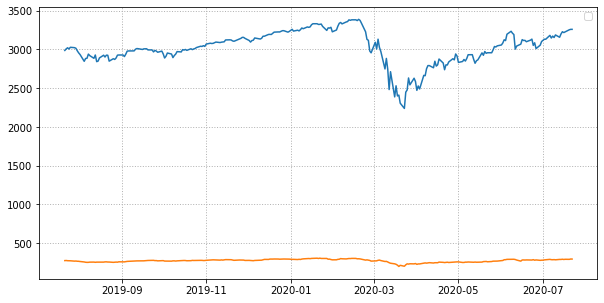

In [9]:
#맷플롯립을 이용해 그래프 그리기
import matplotlib.pyplot as plt
%matplotlib inline 
#이 명령이 없으면 만들어진 그래프를 별도의 화면으로 확인해야 함 -> 노트북 워크스페이스상의 결과화면에 그래프가 나오도록 저장
#우리가 수집한 kospi200과 S&P500 자료를 이용해 그래프를 그리면
plt.figure(figsize=(10,5)) #크기조절
plt.plot(df['S&P500']) #데이터선택
plt.plot(df['KOSPI200']) 
plt.legend(loc=0) #범례 위치 지정
plt.grid(True, color='0.7', linestyle =':', linewidth=1) #그리드설정

No handles with labels found to put in legend.


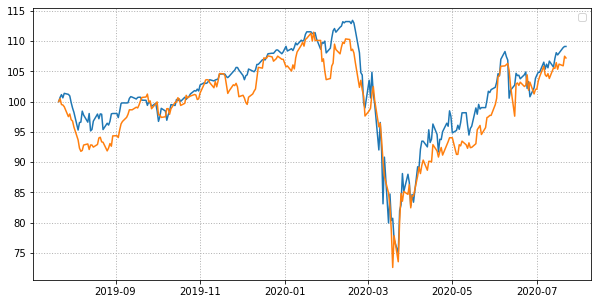

In [10]:
#지수화한 그래프를 다시 그리면
plt.figure(figsize=(10,5))
plt.plot(df['S&P500']/df['S&P500'].loc[dt.date(2019, 7, 22)]*100)
plt.plot(df['KOSPI200']/df['KOSPI200'].loc[dt.date(2019, 7, 22)]*100)
plt.legend(loc=0)
plt.grid(True, color = '0.7',linestyle = ':', linewidth=1)

In [13]:
#특정 기간의 데이터를 보려면
import datetime as dt
df_ratio_now = df.loc[dt.date(2020,1,1):] / df.loc[dt.date(2020,1,2)] *100
df_ratio_now.head(3)

AttributeError: 'DataFrame' object has no attribute 'date'